In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import ceil, floor
from scipy.spatial.distance import cityblock
from matplotlib.path import Path
import matplotlib.patches as patches
import pandas as pd

### Build SOM structure

In [2]:
class SOM():
    def __init__(self, data, weightdim):
        self.weights = np.random.rand(weightdim[0],weightdim[1])
        self.data = data

    def train(self, eta, iterations, data = None, starting_fraction = None, func = None):
        if data == None:
            data = self.data
        if starting_fraction == None:
            starting_fraction = 4
        
        area_size = ceil(self.weights.shape[0]/starting_fraction)
        size_step = area_size/iterations
        for epoch in range(iterations):
            self.iterate(data, area_size, eta, func)
            area_size = self.update_size(area_size, size_step)
            if epoch%10==0:
                print("Completed epoch {}".format(epoch))
    
    def update_size(self, area_size, size_step):
        area_size = max(ceil(area_size - size_step), 1)
        return area_size

    
    def iterate(self, data, area_size, eta, func):
        if func == None:
            func = self.find_neighbourhood
        elif func == 'circular':
            func = self.find_circular_neighbourhood
        elif func == 'manhattan':
            func = self.find_manhattan_neighbourhood
        
        for dataindex in range(data.shape[0]):
            datapoint = data[dataindex,:].copy()
            winner = self.find_winner(datapoint)
            neighbourhood = func(winner, area_size)
            self.update_weights(neighbourhood, eta, datapoint)
            
    def update_weights(self, neighbourhood, eta, datapoint):
        for weight_index in neighbourhood:
            weight = self.weights[weight_index,:].copy()
            new_weight = np.add(weight, eta*(np.subtract(datapoint,weight)))
            self.weights[weight_index,:] = new_weight
            
    def distance(self, x, y):
        sub_vec = np.subtract(x, y)
        dist = np.dot(sub_vec.T, sub_vec)
        return dist
            
    def find_winner(self, datapoint):
        min_dist = self.distance(self.weights[0,:], datapoint)
        min_index = 0
        for weightindex in range(self.weights.shape[0]):
            dist = self.distance(self.weights[weightindex,:], datapoint)
            if dist < min_dist:
                min_dist = dist
                min_index = weightindex
        return min_index
    
    def find_circular_neighbourhood(self, winner, area_size):
        diff = int(area_size/2)
        weight_length = self.weights.shape[0]
        lower = (winner - diff) % weight_length
        upper = (winner + diff) % weight_length
        if lower > upper:
            lower_range = list(range(lower,weight_length))
            upper_range = list(range(0,upper))
            neighbourhood = lower_range.append(upper_range)
        else:
            neighbourhood = range(lower,upper)

        return range(lower, upper)
    
    def find_manhattan_neighbourhood(self, winner, area_size):
        grid_winner = np.array([floor(winner/10), winner % 10])
        neighbourhood = []

        for i in range(100):
            i_grid = np.array([floor(i/10), i % 10])
            if cityblock(grid_winner, i_grid) <= area_size:
                neighbourhood.append(i)
        return neighbourhood
    
    def find_neighbourhood(self, winner, area_size):
        diff = int(area_size/2)
        max_ind = self.weights.shape[0]
        if area_size == 1:
            if winner == max_ind:
                lower = winner -1
                upper = winner
            else:
                lower = winner
                upper = min(winner+1, max_ind)
        elif area_size == 2:
            if np.random.rand() > 1:
                lower = winner
                upper = min(winner + 2, max_ind)
            else:
                lower = max(winner-2, 0)
                upper = winner
        else:
            lower = max(winner - diff, 0)
            upper = min(winner + diff, max_ind)
        
        neighbourhood = range(lower,upper)
        return neighbourhood
    
    def predict(self, data, labels):
        predictions = []
        for dataindex in range(data.shape[0]):
            datapoint = data[dataindex,:].copy()
            winner = self.find_winner(datapoint)
            predictions.append([winner, labels[dataindex]])
        predictions = np.array(predictions,dtype=object)
        predictions = predictions[predictions[:,0].argsort()]
  
        return predictions
        
        

In [3]:
for index in range(8,4):
    print(index)

### Animal Ordering

In [4]:
animal_data = np.loadtxt('data/animals.dat', delimiter = ',', dtype = int)
animalNames = np.loadtxt('data/animalnames.txt', dtype = str)

In [5]:
animal_data = np.reshape(animal_data, (32,84))

In [6]:
som = SOM(animal_data, (100, 84))
som.train(0.1, 100)
pred = som.predict(animal_data, animalNames)

Completed epoch 0
Completed epoch 10
Completed epoch 20
Completed epoch 30
Completed epoch 40
Completed epoch 50
Completed epoch 60
Completed epoch 70
Completed epoch 80
Completed epoch 90


In [7]:
print(pred)

[[0 "'antelop'"]
 [0 "'kangaroo'"]
 [0 "'bat'"]
 [0 "'giraffe'"]
 [0 "'skunk'"]
 [0 "'camel'"]
 [0 "'pig'"]
 [0 "'rabbit'"]
 [3 "'lion'"]
 [3 "'rat'"]
 [3 "'cat'"]
 [3 "'ape'"]
 [3 "'hyena'"]
 [4 "'horse'"]
 [4 "'elephant'"]
 [12 "'bear'"]
 [12 "'dog'"]
 [16 "'seaturtle'"]
 [16 "'walrus'"]
 [16 "'crocodile'"]
 [24 "'frog'"]
 [36 "'ostrich'"]
 [36 "'pelican'"]
 [36 "'penguin'"]
 [36 "'duck'"]
 [49 "'spider'"]
 [62 "'moskito'"]
 [62 "'housefly'"]
 [74 "'butterfly'"]
 [86 "'beetle'"]
 [86 "'grasshopper'"]
 [99 "'dragonfly'"]]


### TSP

In [8]:
cities_data = np.loadtxt('data/cities.dat', delimiter = ',', dtype = float)
cities_labels = list(range(len(cities_data)))

In [9]:
som =  SOM(cities_data, (10,2))
som.train(0.1, 100, starting_fraction = 4, func = 'circular')
cities_prediction = som.predict(cities_data, cities_labels)

Completed epoch 0
Completed epoch 10
Completed epoch 20
Completed epoch 30
Completed epoch 40
Completed epoch 50
Completed epoch 60
Completed epoch 70
Completed epoch 80
Completed epoch 90


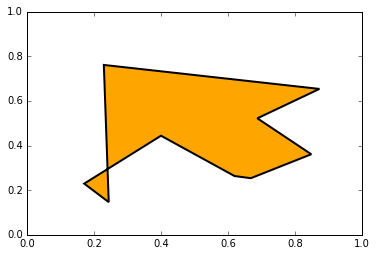

In [10]:
verts = np.empty(cities_data.shape)
i = 0
for index in cities_prediction[:,1]:
    verts[i] = cities_data[index,:]
    i += 1

codes = [Path.LINETO]*len(cities_data)
codes[0] = Path.MOVETO
codes[-1] = Path.CLOSEPOLY

path = Path(verts, codes)
fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

### Votes of MPs

In [11]:
votes = np.loadtxt('data/votes.dat', delimiter = ',', dtype = float)
mpnames = np.genfromtxt('data/mpnames.txt', delimiter ='\n', dtype = str)
mpsex  = np.genfromtxt('data/mpsex.dat', delimiter =',', dtype = float)
mpdistrict  = np.genfromtxt('data/mpdistrict.dat', delimiter =',', dtype = float)
mpparty = np.genfromtxt('data/mpparty.dat', delimiter =',', dtype = float)
votes = np.reshape(votes,(349,31))
votes_labels = list(range(len(votes)))

In [12]:
len(mpsex)

349

In [13]:
som =  SOM(votes, (100,31))
som.train(0.1, 100, starting_fraction = 50, func = 'manhattan')
votes_prediction = som.predict(votes, votes_labels)

Completed epoch 0
Completed epoch 10
Completed epoch 20
Completed epoch 30
Completed epoch 40
Completed epoch 50
Completed epoch 60
Completed epoch 70
Completed epoch 80
Completed epoch 90


In [14]:
def to_grid(data):
    result = np.empty((349,2))
    i = 0
    for datapoint in data:
        x = floor(datapoint/10)
        y = datapoint%10
        result[i, 0] = x
        result[i, 1] = y
        i = i+1
    return result

In [15]:
npgrid = to_grid(votes_prediction[:,0])
unique, counts = np.unique(npgrid, return_counts=True, axis = 0)
counts = counts.reshape(unique.shape[0],1)
compact_grid = np.column_stack((unique,counts))

In [16]:
names = (pd.DataFrame(mpnames)
             .rename(columns={0:'names'})
             .reindex(votes_prediction[:,1])
             .reset_index()
             .rename(columns={'index':'id'}))
sex = (pd.DataFrame(mpsex)
             .rename(columns={0:'sex'})
             .reindex(votes_prediction[:,1])
             .reset_index()
             .rename(columns={'index':'id'}))
district = (pd.DataFrame(mpdistrict)
             .rename(columns={0:'district'})
             .reindex(votes_prediction[:,1])
             .reset_index()
             .rename(columns={'index':'id'}))
party = (pd.DataFrame(mpparty)
             .rename(columns={0:'party'})
             .reindex(votes_prediction[:,1])
             .reset_index()
             .rename(columns={'index':'id'}))


In [17]:
grid = (pd.DataFrame(npgrid)
          .rename(columns={0:'x',1:'y'}))
grid['original_output'] = votes_prediction[:,0]
grid['id'] = votes_prediction[:,1]


#Merge shit here!
grid = (grid.merge(names, how ='left', on='id')
            .merge(sex, how = 'left', on ='id')
            .merge(district, how ='left', on = 'id')
            .merge(party, how ='left', on='id')
            .merge(pd.DataFrame(compact_grid).rename(columns={0:'x',1:'y',2:'count'}), on =['x','y'], how = 'left'))

In [18]:
grid.head()

,x,y,original_output,id,names,sex,district,party,count
0,0.0,0.0,0,47,Svensson Ingvar,0.0,2.0,6.0,22.0
1,0.0,0.0,0,173,Althin Peter,0.0,13.0,6.0,22.0
2,0.0,0.0,0,142,Gylling Johnny,0.0,10.0,6.0,22.0
3,0.0,0.0,0,195,Gustafsson Lars,0.0,15.0,6.0,22.0
4,0.0,0.0,0,129,Palsson Chatrine,1.0,8.0,6.0,22.0


### SEX

186


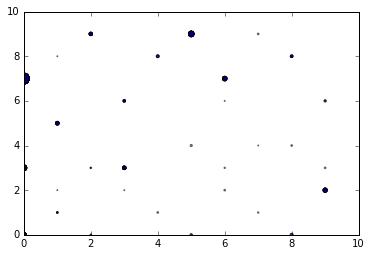

163


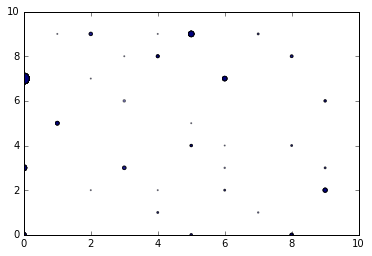

In [19]:
for value in grid['sex'].unique():
    df = grid[grid.sex==value]
    plt.scatter(df['x'], df['y'], s=df['count'], c=df['sex'],alpha=0.5)
    axes = plt.gca()
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    print(len(df))
    plt.show()

### PARTY

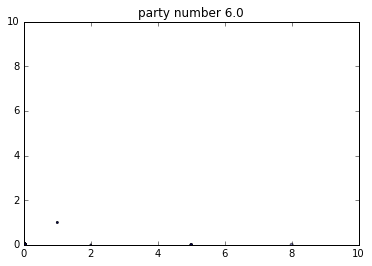

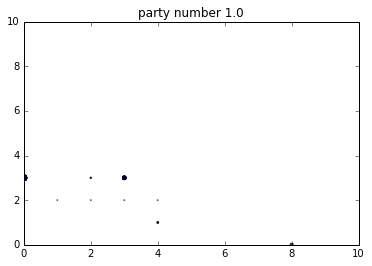

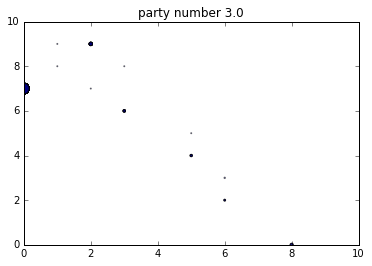

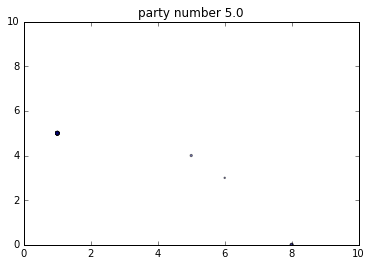

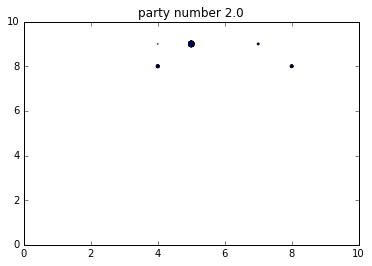

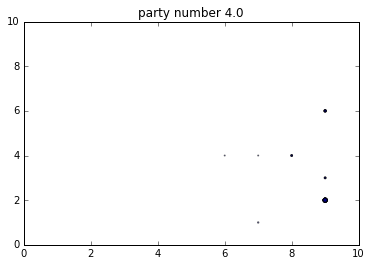

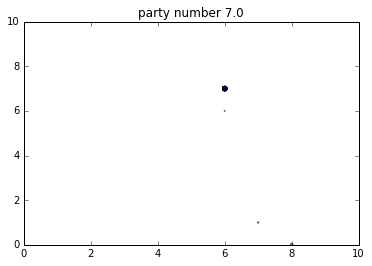

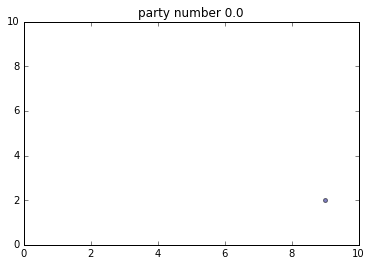

In [20]:
for value in grid['party'].unique():
    df = grid[grid.party==value]
    plt.scatter(df['x'], df['y'], s=df['count'], c=df['party'],alpha=0.5)
    axes = plt.gca()
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    plt.title('party number {}'.format(value))
    plt.show()

### DISTRICT

39


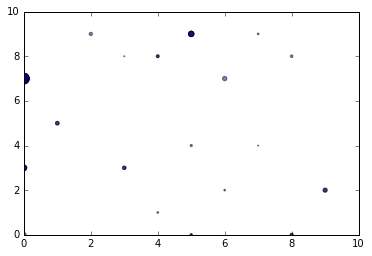

14


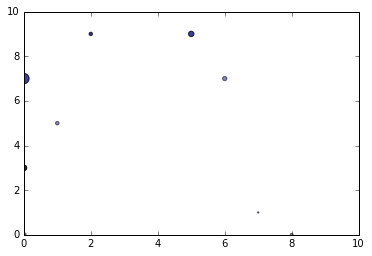

6


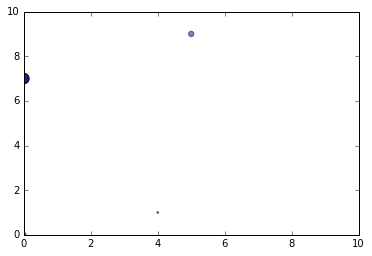

11


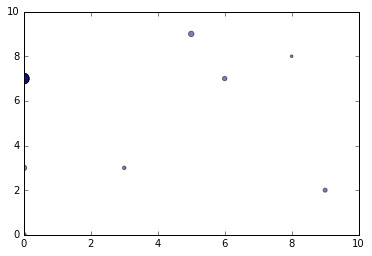

9


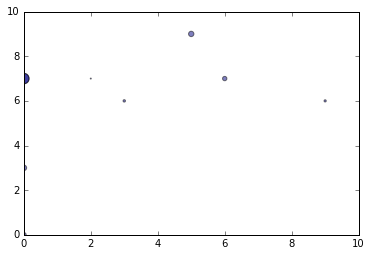

7


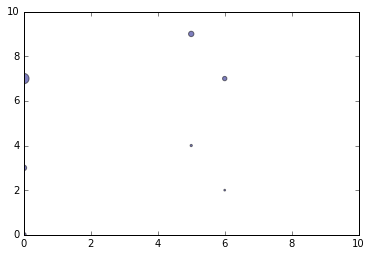

18


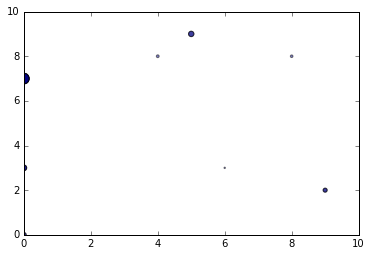

13


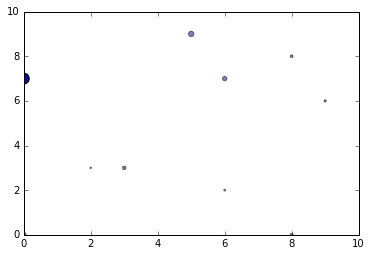

7


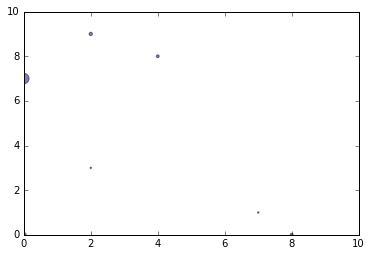

10


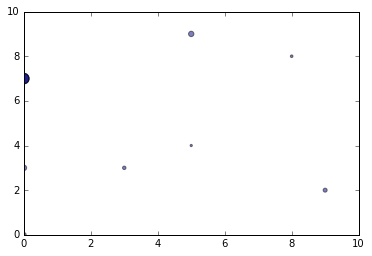

9


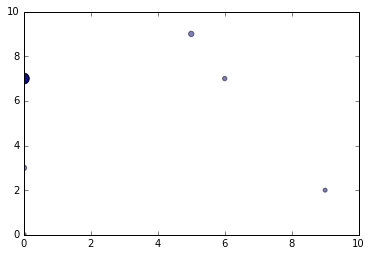

17


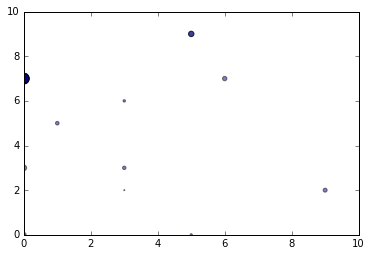

29


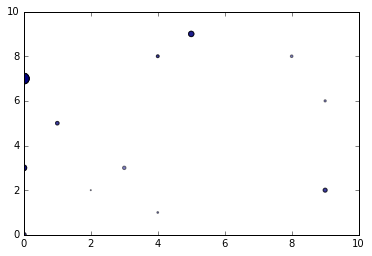

11


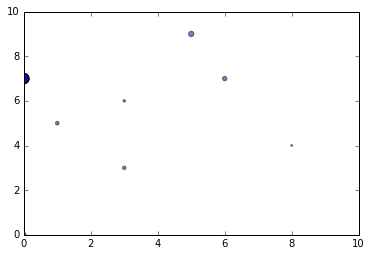

11


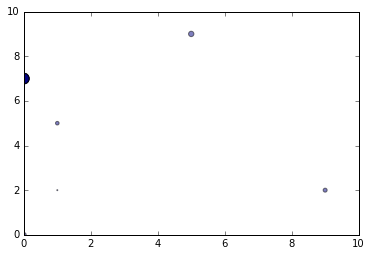

11


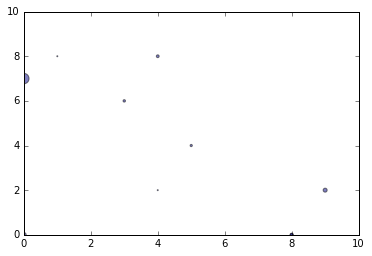

11


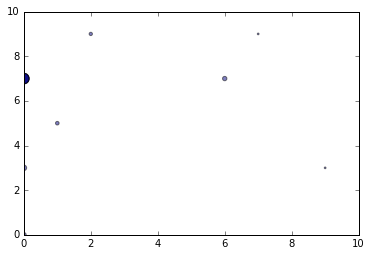

11


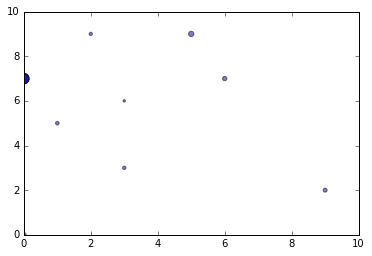

10


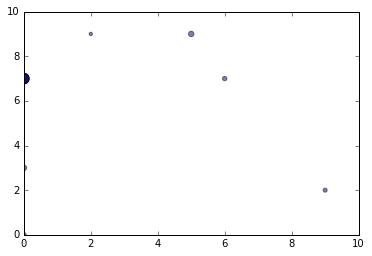

10


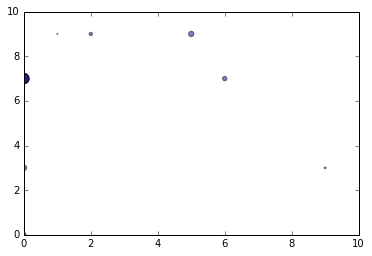

12


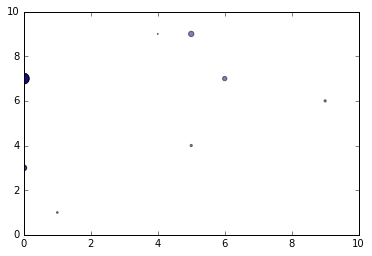

9


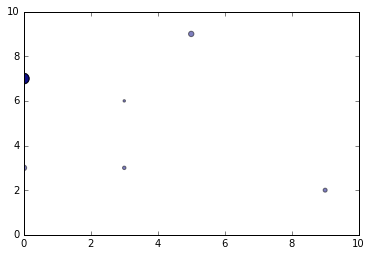

11


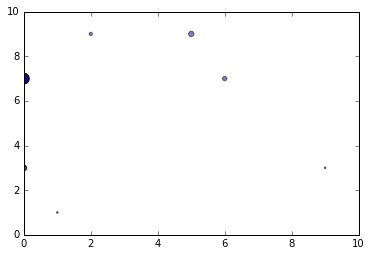

10


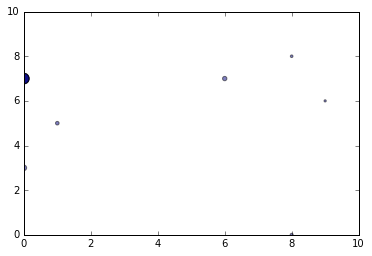

11


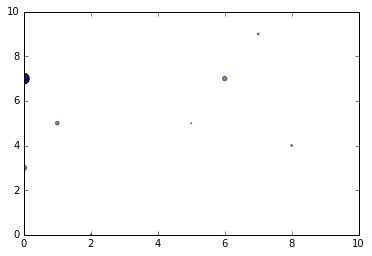

11


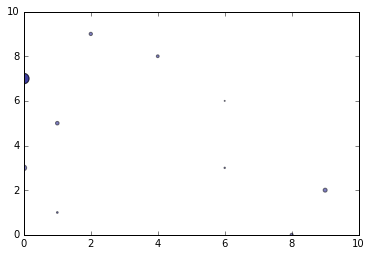

6


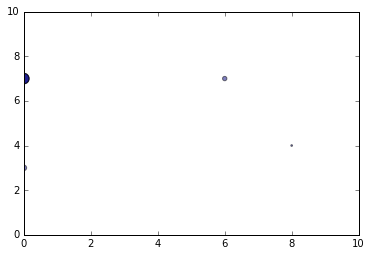

2


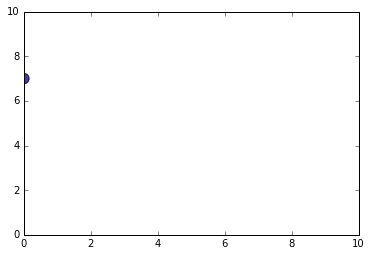

13


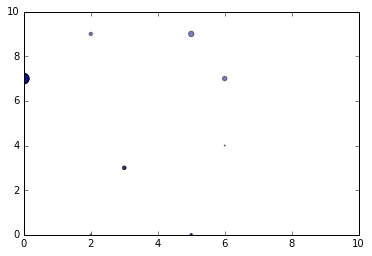

In [21]:
for value in grid['district'].unique():
    df = grid[grid.district==value]
    plt.scatter(df['x'], df['y'], s=df['count'], c=df['district'],alpha=0.5)
    axes = plt.gca()
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    print(len(df))
    plt.show()

In [22]:
grid.district.value_counts()

2.0     39
1.0     29
16.0    18
5.0     17
13.0    14
17.0    13
6.0     13
3.0     12
29.0    11
24.0    11
25.0    11
4.0     11
28.0    11
15.0    11
22.0    11
14.0    11
21.0    11
23.0    10
26.0    10
18.0    10
12.0    10
8.0      9
11.0     9
20.0     9
7.0      7
19.0     7
10.0     6
27.0     6
9.0      2
Name: district, dtype: int64